In [95]:
import math
import numpy as np
import PIL
from matplotlib import pyplot as plt
from PIL import Image
import time

def read_image(image_path):
    """Read an image into a numpy array.

    Args:
        image_path: Path to the image file.

    Returns:
        Numpy array containing the image
    """
    img = Image.open(image_path)
    return np.array(img)


def write_image(image, out_path):
    """Writes a numpy array as an image file.

    Args:
        image: Numpy array containing image to write
        out_path: Path for the output image
    """
    image = (image*255.0).astype('uint8')
    img = Image.fromarray(image)
    img.save(out_path)


def display_image(image):
    """Displays a grayscale image using matplotlib.

    Args:
        image: HxW Numpy array containing image to display.
    """
    image = (image*255.0).astype('uint8')
    return plt.imshow(image, cmap="gray")


def convert_to_grayscale(image):
    """Convert an RGB image to grayscale.

    Args:
        image: HxWx3 uint8-type Numpy array containing the RGB image to convert.

    Returns:
        uint8-type Numpy array containing the image in grayscale
    """
    H, W = image.shape[0], image.shape[1]
    grarray = np.zeros((H, W), dtype='uint8')
    for row in range(H):
        for col in range(W):
            pixel = image[row][col]
            R, G, B = pixel[0], pixel[1], pixel[2]
            L = (299/1000) * R + (587/1000) * G + (114/1000) * B
            grarray[row][col] = int(L)
    return grarray


def convert_to_float(image):
    """Convert an image from 8-bit integer to 64-bit float format

    Args:
        image: Integer-valued numpy array with values in [0, 255]
    Returns:
        Float-valued numpy array with values in [0, 1]
    """

    return image.astype('float64') / 255.0


def convolution(image, kernel):
    """Convolves image with kernel.

    The image should be zero-padded so that the input and output image sizes
    are equal.
    Args:
        image: HxW Numpy array, the grayscale image to convolve
        kernel: hxw numpy array
    Returns:
        image after performing convolution
    """
    H, W = image.shape
    h, w = kernel.shape
    k = (h - 1) // 2    #1/2 height
    l = (w - 1) // 2    #1/2 side  
    np.flipud(kernel)
    np.fliplr(kernel)
    convd = np.zeros((H, W))
    for row in range(H):
        for col in range(W):
            acc = 0
            for r in range(-k, k+1):
                for c in range(-l, l+1):
                    above = r + row < 0
                    below = r + row > H - 1
                    left = c + col < 0
                    right = c + col > W - 1
                    if not (above or below or left or right):
                        acc += image[row+r][col+c] * kernel[r][c]
            convd[row][col] = acc
    return convd



def gaussian_blur(image, ksize=3, sigma=1.0):
    """Blurs image by convolving it with a gaussian kernel.

    Args:
        image: HxW Numpy array, the grayscale image to blur
        ksize: size of the gaussian kernel
        sigma: variance for generating the gaussian kernel

    Returns:
        The blurred image
    """
    
    start_time = time.time()
    
    kernel = np.zeros((ksize, ksize))
    acc = 0
    radius = (ksize - 1) // 2
    for row in range(-radius, radius+1):
        for col in range(-radius, radius+1):
            val = math.exp(-(row**2+col**2)/(2*(sigma**2)))
            acc += val
            kernel[row+radius][col+radius] = val
    
    print("My program took", time.time() - start_time, "to run")
    return convolution(image, kernel/acc)
    


def sobel_filter(image):
    """Detects image edges using the sobel filter.

    The sobel filter uses two kernels to compute the vertical and horizontal
    gradients of the image. The two kernels are:
    G_x = [-1 0 1]      G_y = [-1 -2 -1]
          [-2 0 2]            [ 0  0  0]
          [-1 0 1]            [ 1  2  1]

    After computing the two gradients, the image edges can be obtained by
    computing the gradient magnitude.

    Args:
        image: HxW Numpy array, the grayscale image
    Returns:
        HxW Numpy array from applying the sobel filter to image
    """
    G_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    G_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    
    return convolution(convolution(image, G_y), G_x)


def dog(image, ksize1=5, sigma1=1.0, ksize2=9, sigma2=2.0):
    """Detects image edges using the difference of gaussians algorithm

    Args:
        image: HxW Numpy array, the grayscale image
        ksize1: size of the first gaussian kernel
        sigma1: variance of the first gaussian kernel
        ksize2: size of the second gaussian kernel
        sigma2: variance of the second gaussian kernel
    Returns:
        HxW Numpy array from applying difference of gaussians to image
    """
    return gaussian_blur(image, ksize1, sigma1) - gaussian_blur(image, ksize2, sigma2)


def dft(image):
  """Computes the discrete fourier transform of image

  This function should return the same result as
  np.fft.fftshift(np.fft.fft2(image)). You may assume that
  image dimensions will always be even.

  Args:
    image: HxW Numpy array, the grayscale image
  Returns:
    NxW complex Numpy array, the fourier transform of the image
  """
  pass


def idft(ft_image):
  """Computes the inverse discrete fourier transform of ft_image.

  For this assignment, the complex component of the output should be ignored.
  The returned array should NOT be complex. The real component should be
  the same result as np.fft.ifft2(np.fft.ifftshift(ft_image)). You
  may assume that image dimensions will always be even.

  Args:
    ft_image: HxW complex Numpy array, a fourier image
  Returns:
    NxW float Numpy array, the inverse fourier transform
  """
  pass


def visualize_kernels():
    """Visualizes your implemented kernels.

    This function should read example.png, convert it to grayscale and float-type,
    and run the functions gaussian_blur, sobel_filter, and dog over it. For each function,
    visualize the result and save it as example_{function_name}.png e.g. example_dog.png.
    This function does not need to return anything.
    """
    example = convert_to_float(read_image("example.png"))
    
    gauss = gaussian_blur(example)
    display_image(gauss)
    write_image(gauss, "example_gaussian_blur.png")

    sobel = sobel_filter(example)
    display_image(sobel)
    write_image(sobel, "example_sobel_filter.png")
    
    dg = dog(example)
    display_image(dg)
    write_image(dg, "example_dog.png")

def visualize_dft():
  """Visualizes the discrete fourier transform.

  This function should read example.png, convert it to grayscale and float-type,
  and run dft on it. Try masking out parts of the fourier transform image and
  recovering the original image using idft. Can you create a blurry version
  of the original image? Visualize the blurry image and save it as example_blurry.png.
  This function does not need to return anything.
  """
  pass



In [74]:
example = read_image("example.png")
example = convert_to_float(example)
print(example)

[[0.45490196 0.44705882 0.43137255 ... 0.30980392 0.36862745 0.42745098]
 [0.44705882 0.43529412 0.41960784 ... 0.29411765 0.34509804 0.40392157]
 [0.44313725 0.42745098 0.41568627 ... 0.2627451  0.30980392 0.35686275]
 ...
 [0.86666667 0.8        0.72941176 ... 0.17647059 0.20784314 0.23921569]
 [0.92941176 0.86666667 0.78431373 ... 0.19607843 0.23137255 0.25882353]
 [0.98431373 0.91764706 0.83921569 ... 0.21960784 0.25490196 0.27843137]]


In [75]:
k = np.zeros((5,5)) + (1/25)
display_image(convolution(convert_to_grayscale(read_image('dogbike.jpg')), k))

KeyboardInterrupt: 

In [ ]:
display_image(convert_to_grayscale(read_image('dogbike.jpg')))

My program took 2.6941299438476562e-05 to run


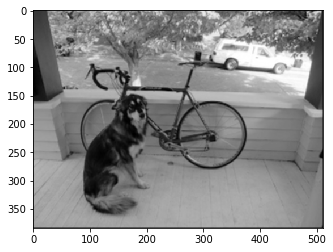

In [54]:
display_image(gaussian_blur(convert_to_grayscale(read_image('dogbike.jpg')), 3,1))

[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
[[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]
[[0.45490196 0.44705882 0.43137255 ... 0.30980392 0.36862745 0.42745098]
 [0.44705882 0.43529412 0.41960784 ... 0.29411765 0.34509804 0.40392157]
 [0.44313725 0.42745098 0.41568627 ... 0.2627451  0.30980392 0.35686275]
 ...
 [0.86666667 0.8        0.72941176 ... 0.17647059 0.20784314 0.23921569]
 [0.92941176 0.86666667 0.78431373 ... 0.19607843 0.23137255 0.25882353]
 [0.98431373 0.91764706 0.83921569 ... 0.21960784 0.25490196 0.27843137]]


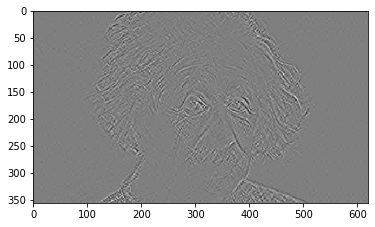

In [82]:
display_image(sobel_filter(example))

In [68]:
a = sobel_filter(example)
print(a)

[[ 0.08039216  0.0245098  -0.00196078 ...  0.00931373  0.0125
  -0.04117647]
 [ 0.07990196  0.0252451  -0.00563725 ...  0.00686275  0.00808824
  -0.03382353]
 [-0.00563725 -0.00171569 -0.0002451  ... -0.00833333 -0.00637255
   0.01568627]
 ...
 [ 0.04509804  0.00710784 -0.00980392 ...  0.00220588  0.00171569
  -0.00416667]
 [ 0.03946078  0.0125     -0.00318627 ...  0.00269608 -0.00098039
  -0.01004902]
 [ 0.02205882  0.00637255 -0.00245098 ...  0.00147059 -0.00073529
  -0.00514706]]


My program took 0.0001049041748046875 to run
My program took 0.00011610984802246094 to run


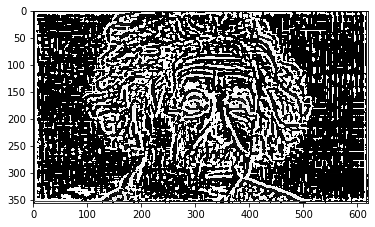

In [96]:
display_image(dog(example))

My program took 3.695487976074219e-05 to run
My program took 0.00010585784912109375 to run
My program took 0.0001380443572998047 to run


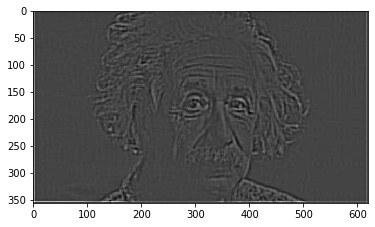

In [94]:
visualize_kernels()